## introduction
### problem statement
Every day always more people experience the opportunity of training overywhere: outdoor on a park, in a garage, in our bedroom etc. Anyway this possibility of freedom led to a great issue commont to every uncommon athlets: the lack of feedbacks.
infact, while in a gym is easy receive a examination on own exercise esecution, by a trainer or by another athlet, on own bedroom we don't have this possibility. lack of feedback on exercise esecution led to learn improper esecutin, bring to weak performances, injuries etc

### state of art 
to evaluete own proper execution, athlets sometimes use to record their performarce in order to self esaminate them and find what is wrong. Anyway this process is tedios becouse it involve the need to find a good place to put the smartphone,record the clip, skip all the preparation of exercise, find the most significative point on the esecution, examinate them and finaly understaining whats wrong for correcting mistakes on the next repetition.
Do this proces for every rep, for every exercise, in time with rest time (usualy in the order of 1 minute), can be annoing and most athlets preferes to not be distracted and keep attention on their work out.

### proposed solution 
my idea is to make all this process agile for the atlets, developing a computer vision pipeline that is able  to take the recordered clip, extrapolate the most important keyframe for the athlets, discard all the unnecessary moment to be keep user attention on the most important moment and give to final user a edited clipp to fast evaluate own performances


# First part: Deep Learning

In [171]:
import numpy as np
import torch
import pytorch_lightning as pl
import os, os.path
import fnmatch
from tqdm.notebook import tqdm, trange
from math import pi, sqrt, exp

from skimage import color
import skimage.measure
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader 
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from scipy.signal import find_peaks
import cv2
import matplotlib.pyplot as plt
from pytorch_lightning.strategies import DDPStrategy
import flow_transforms
import flowiz as fz
from pytorch_lightning.callbacks import ModelCheckpoint
"""
global variable
"""
div_flow=20

# datasets

### Data module for Flow dataset

In [172]:
class FlowDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, workers,dataset="sintel" , camera='left'):
        super().__init__()

        self.download_dir = './root'    # Directory to store FlyingChairs Data     
        self.batch_size =  batch_size   # Defining batch size of our data 
        self.workers =    workers      
        self.camera = camera
        self.dataset=dataset
        
        self.input_transform=transforms.Compose( [flow_transforms.ArrayToTensor(),
                                           transforms.Normalize(mean=[0,0,0], std=[255,255,255]), 
                                            transforms.Normalize(mean=[0.45,0.432,0.411], std=[1,1,1])])
                                           
        self.flow_transforms= transforms.Compose([  flow_transforms.FlowToTensor(),
                                            transforms.Normalize(mean=[0,0],std=[div_flow,div_flow])])
        # Defining transforms to be applied on the data
    
    def dataset_transformation(self, input1, input2,flow, valid_flow_mask):
        """
              train_transform takes data from torchVision Flyingchairs dataset and return a tensor ready for model training
              I choice to not performe data augmentation: dataset is so huge that overcome my computational capabilities :(,
              so i don't need to have more of theme :)
        """
        valid_flow_mask= None  #put none valid_flow_mask (only for compatibility with other dataset)
         #from PIL image to numpy
        input1 = np.asarray(input1)
        input2 = np.asarray(input2)
        flow= np.asarray(flow)
        input1= self.input_transform(input1)
        input2= self.input_transform(input2)       
        flow=self.flow_transforms(flow)     
        
        return input1, input2 , flow, valid_flow_mask
    
    def setup(self, stage=None):
        
        if(self.dataset == "FlyingThings3D"):
                self.train_data = datasets.FlyingThings3D(self.download_dir,
                              split = "train", 
                              transforms = self.dataset_transformation,
                              pass_name = self.pass_name,
                              camera=  self.camera                   )

                self.test_data = datasets.FlyingThings3D(self.download_dir,
                                        split = "val",
                                        transforms = self.dataset_transformation,
                                        pass_name = self.pass_name,
                                        camera=  self.camera               
                                                        )
        if(self.dataset == "FlyingChairs"):
            self.train_data = datasets.FlyingChairs(self.download_dir,
                              split = "train", 
                              transforms = self.dataset_transformation)

            self.test_data = datasets.FlyingChairs(self.download_dir,
                                        split = "val",
                                        transforms = self.dataset_transformation,
                                              )
        if(self.dataset=="Sintel"):   
            self.train_data = datasets.Sintel(self.download_dir,
                              split = "train", 
                              transforms = self.dataset_transformation,
                              pass_name = "clean"                  )

            self.test_data = datasets.Sintel(self.download_dir,
                                        split = "train",
                                        transforms = self.dataset_transformation,
                                        pass_name = "final"
                                                        )
  
    def train_dataloader(self):
        
          # Generating train_dataloader
        return DataLoader(self.train_data, 
                          batch_size = self.batch_size,
                          num_workers = self.workers )

    def test_dataloader(self):
        
        # Generating test_dataloader
        return DataLoader(self.test_data,
                          batch_size = self.batch_size,
                          num_workers = self.workers )

## understanding dataset


let's visualize how torch vison dataset FlyingChairs works

In [173]:
dataModulo= FlowDataModule(batch_size = 8,workers=32)
loadedDataset= datasets.Sintel(root='./root',
                              split = "train", 
                              transforms = dataModulo.dataset_transformation,
                              pass_name = "clean"
                                )

root/Sintel/training/clean


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
flow image in dataset has shape: torch.Size([2, 436, 1024])
image1 in dataset has shape: torch.Size([3, 436, 1024])
image2 in dataset has shape: torch.Size([3, 436, 1024])
flow image in dataset has this new shape: torch.Size([436, 1024, 2])
image1 in dataset has this new shape: torch.Size([436, 1024, 3])
image2 in dataset has this new shape: torch.Size([436, 1024, 3])


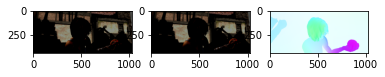

In [174]:
"""
dataset gives back triplets [image1,image2, targetFlow]
"""

triplet=loadedDataset[10]
img1,img2,flow= triplet
print(type(img1))
print (f"flow image in dataset has shape: {flow.shape}")
print (f"image1 in dataset has shape: {img1.shape}")
print (f"image2 in dataset has shape: {img2.shape}")
'''
we can notice that pictures have the wrong shape for visualization porpuse, (is right for training)
so we will need to transpose the dataset to be able to visualize dataset triplets
'''

img1=np.transpose (img1,(1,2,0))
img2=np.transpose (img2,(1,2,0))
flow=np.transpose (flow,(1,2,0))

print (f"flow image in dataset has this new shape: {flow.shape}")
print (f"image1 in dataset has this new shape: {img1.shape}")
print (f"image2 in dataset has this new shape: {img2.shape}")

"""
 attention, input pictures are shown darken then original dataset. This is given by trasform trainset normalization
"""
flow=fz.convert_from_flow(flow.cpu().detach().numpy()) #i use flowviz to convert flow to image

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(flow)



## model 

### model basic blocks

In [175]:
def convolution_unit(in_channels, out_channels, kernel_size=3, stride=1):
     return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )

In [176]:
def deconvolution_unit(in_channels, out_channels):
    return nn.Sequential ( nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                           nn.LeakyReLU(negative_slope=0.1,inplace=True)
                        )

In [177]:
def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

In [178]:
def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)

In [179]:
def correlate(input1, input2):
    out_corr = spatial_correlation_sample(input1,
                                          input2,
                                          kernel_size=1,
                                          patch_size=21,
                                          stride=1,
                                          padding=0,
                                          dilation_patch=2)

### FlowNetS

In [180]:
class FlowNetS(pl.LightningModule):
    def __init__(self, checkpoint=None):
        super().__init__()
        
        #ENCODER PART OF THE NETWORK
       
        self.conv1   = convolution_unit( 6,   64, kernel_size=7, stride=2)
        self.conv2   = convolution_unit(  64,  128, kernel_size=5, stride=2)
        self.conv3   = convolution_unit(128,  256, kernel_size=5, stride=2)
        self.conv3_1 = convolution_unit( 256,  256)
        self.conv4   = convolution_unit( 256,  512, stride=2)
        self.conv4_1 = convolution_unit( 512,  512)
        self.conv5   = convolution_unit( 512,  512, stride=2)
        self.conv5_1 = convolution_unit( 512,  512)
        self.conv6   = convolution_unit( 512, 1024, stride=2)
        self.conv6_1 = convolution_unit(1024, 1024)      
        
        #REFINEMENT PART OF THE NETWORK
        self.deconv5 = deconvolution_unit(1024,512)
        self.deconv4 = deconvolution_unit(1026,256)
        self.deconv3 = deconvolution_unit(770,128)
        self.deconv2 = deconvolution_unit(386,64)

        self.predict_flow6 = predict_flow(1024) 
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        
        if(checkpoint is not None):
             self.load_state_dict(checkpoint)
                
    def forward (self, x):
        # ENCODER
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))
        
        # REFINEMENT
        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)
        
        return flow2,flow3,flow4,flow5,flow6
      
        
    def training_step(self, batch, batch_idx):
        multiscale_weights = [0.005,0.01,0.02,0.08,0.32] # how i weight loss on every level
         # i want to obtain the y resized to various level, in order to compute loss function:

        x,x1, y= batch    
        tensors= []
        for i in range(len(x1)):
            
            cat= torch.cat((x[i],x1[i]),0)
            cat= torch.reshape(cat, (1, *cat.size()))
            tensors.append(cat)
            
        x_train= torch.cat(tensors,0)
        output=self(x_train) 
        h, w = y.size()[-2:]  
    
        output = [F.interpolate(output[0], (h,w)), *output[1:]] # it upscale output image to make confrontable y with output      
        loss = multiscaleEPE(output, y, weights=multiscale_weights)
        self.log('train_loss', loss)
        return loss


    def test_step(self, batch, batch_idx):

        x,x1, y= batch    
        tensors= []
        for i in range(len(x1)):
            
            cat= torch.cat((x[i],x1[i]),0)
            cat= torch.reshape(cat, (1, *cat.size()))
            tensors.append(cat)
            
        x_train= torch.cat(tensors,0)
        output=self(x_train) 
        h, w = y.size()[-2:]  
    
        output = [F.interpolate(output[0], (h,w)), *output[1:]] # it upscale output image to make confrontable y with output      
        loss =  realEPE(output[0], y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
  
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-7, betas=(0.9, 0.999))
        return optimizer
    
    def save(self, path= '/models'):
        torch.save(self.state_dict(), path)

### Loss function 

In [181]:
"""
adapted by nvidia flownet 2.0 implementation and clement pinard flownet implementation
"""

def EPE(input_flow, target_flow, ):
    """
        return the expectation error between input and output flow, like in original paper
    """
    return torch.abs(target_flow-input_flow).mean()
    
def realEPE(output, target):
    """
        return the expectation error between input and output flow, performing the upsample of the computed flow
    """
    b, _, h, w = target.size()
    upsampled_output = F.interpolate(output, (h,w), mode='bilinear', align_corners=False) # used to resize the output
    return EPE(upsampled_output, target)


def multiscaleEPE(network_output, target_flow, weights=None):
    """
        input: network_output: batchtensor with all the computer flows at differents scale
        output: EPE between the computed flows and the groundtruth, weighted at different scales by a weight vector
    """
    def one_scale(output, target):

        b, _, h, w = output.size()                            # obtain batch size, hight and widht
       
        target_scaled = F.interpolate(target, (h, w), mode='area')    # down-size using nn.functional.interpolation
        return EPE(output, target_scaled)
    
# we must be shure that network_output is a list
    if type(network_output) not in [tuple, list]:
        network_output = [network_output]
    if weights is None:
        weights = [0.005, 0.01, 0.02, 0.08, 0.32]  # as in original article
    assert(len(weights) == len(network_output))

    loss = 0
    for output, weight in zip(network_output, weights):
        loss += weight * one_scale(output, target_flow)
    return loss

## model training

### multi GPU training

compile this notebook as script and transform this cell in a code cell
export PL_TORCH_DISTRIBUTED_BACKEND=gloo 
data=FlowDataModule(batch_size =8, workers=32,dataset ="Sintel")
model = FlowNetS.load_from_checkpoint("lightning_logs/version_2788/checkpoints/epoch=11-step=1572.ckpt")
if __name__ == "__main__": 
      ddp= DDPStrategy(find_unused_parameters=False)
      trainer = pl.Trainer(gpus= torch.cuda.device_count(), max_epochs=30, progress_bar_refresh_rate=20,strategy= ddp)
      trainer.fit(model,data)


### single GPU training

In [182]:
# save = torch.load("models/flownets.pth.tar.pth")
# model  = FlowNetS(save)
# data=FlowDataModule(batch_size =8, workers=32,dataset ="Sintel")
# trainer = pl.Trainer(gpus=1, max_epochs=200, progress_bar_refresh_rate=20)
# trainer.fit(model,data )


## model validation

In [183]:
# results=[]
# trainer = pl.Trainer(gpus=1, max_epochs=200, progress_bar_refresh_rate=20)
# data=FlowDataModule(batch_size =8, workers=32,dataset ="Sintel")
# save = torch.load("models/flownets.pth.tar.pth")

# models= [ FlowNetS(checkpoint=save),
#           FlowNetS.load_from_checkpoint("lightning_logs/60_epochs/checkpoints/epoch=64-step=8515.ckpt"),
#           FlowNetS.load_from_checkpoint("lightning_logs/100_epochs/checkpoints/epoch=99-step=13100.ckpt"),
#           FlowNetS.load_from_checkpoint("lightning_logs/150_epochs/checkpoints/epoch=49-step=6288.ckpt"),
#           FlowNetS.load_from_checkpoint("lightning_logs/350_epochs/checkpoints/epoch=199-step=26200.ckpt")
#         ]
# for net in models:
#     score=trainer.test(net, data)
#     results.append(score[0]["test_loss"])
    

# plt.plot([0,60,100,150,350],results)
# plt.show()

# Second part: Computing Pipeline

## devices and variable

In [184]:
device = torch.device("cuda")
model  =   FlowNetS.load_from_checkpoint("lightning_logs/350_epochs/checkpoints/epoch=199-step=26200.ckpt")
model.to(device)
video_path= "./workout_video/push-up.mp4"

## utilities 

In [185]:
def load_flo(path):
    with open(path, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        print(magic)
        assert(202021.25 == magic),'Magic number incorrect. Invalid .flo file'
        h = np.fromfile(f, np.int32, count=1)[0]
        w = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
    # Reshape data into 3D array (columns, rows, bands)
    data2D = np.resize(data, (w, h, 2))
    return data2D

In [186]:
def computeFlow(img1, img2, model, device =device):
    converter=transforms.Compose( [flow_transforms.ArrayToTensor(),
                                           transforms.Normalize(mean=[0,0,0], std=[255,255,255]), 
                                            transforms.Normalize(mean=[0.45,0.432,0.411], std=[1,1,1])])
   
    
    img1=converter(img1).to(device) 
    img2=converter(img2).to(device) 
    x = torch.cat([img1,img2],0)
    
    h, w = img1.shape[1:]  
    x= torch.reshape(x, (1,6,h, w) )
    x.to(device)
    y=model(x)
    
    y_numpy=y[0][0].cpu().detach().numpy()
    y2=np.transpose (y_numpy,(1,2,0))

    flow=fz.convert_from_flow(y2*div_flow) #i use flowviz to convert flow to image
 
    return flow

In [187]:
def saveVideo (images, title, bw=False,frames_rate=24):
    title = title +".avi"
    h,w = images[0].shape[:2]
    if bw is False:
        writer = cv2.VideoWriter(title, cv2.VideoWriter_fourcc(*'PIM1'), frames_rate, (w,h))
    else:
        writer = cv2.VideoWriter(title, cv2.VideoWriter_fourcc(*'PIM1'), frames_rate, (w,h),0)
    for i in tqdm( range(len(images))):
         x = (images[i])
    #     x = cv2.rotate(x, cv2.ROTATE_180)
         writer.write(x)

In [188]:
def import_video(path):
    frames= []
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    while success:
      frames.append(image)
      success,image = vidcap.read()
      count += 1
    print(f'Readed {count}  frames ')
    return frames 

In [189]:
def flow_video(frames):
    flow_frames=[]
    for i in tqdm(range( len(frames)-1)):
        frame=computeFlow(frames[i],frames[i+1],model)
        #frame=cv2.GaussianBlur(frame,(7,7),cv2.BORDER_DEFAULT)
        flow_frames.append(frame)
    return flow_frames

In [190]:
def average_video(frames, buffer=2): 
    average=[]
    
    for i in tqdm(range (buffer,len(frames)-buffer )):
        
        imageList=[]
        for j in range (-buffer,buffer):
            imageList.append(frames[i+j])

        mean= np.mean(imageList, axis=0)
        average.append(mean.astype(np.uint8))
    return average

In [191]:
def kmean(frames, k=3,flag=False):
    #img=cv2.cvtColor(frames.astype(np.uint8),cv2.COLOR_BGR2RGB)

    vectorized = frames.reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    attempts=10
    ret,label,center=cv2.kmeans(vectorized,k,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    
    res = center[label.flatten()]
    result_image = res.reshape((frames.shape))

 
    if (flag is False):
        return    result_image.astype(np.uint8)
    else:
        return result_image.astype(np.uint8), center

def kmeans_video (frames, k=3):
    out= []

    for i in tqdm(range (len(frames) )):
        out.append(kmean(frames[i],k))
    return out    

In [192]:
def find_center_of_gravity(frames):
    centr=[]
    cordinates_x=[]
    cordinates_y=[]
    for i in tqdm(range (len(frames) )):
        frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        frame = 255-frame
        x= (np.mean(frame, axis=0))
        y= (np.mean(frame, axis=1))
        
        x_cord=0
        x_sum = 0
        
        for i in range (len(x)):
            x_cord = x_cord + (x[i]*i)
            x_sum= x_sum+x[i]
        x_cord= x_cord/ x_sum
        cordinates_x.append(x_cord)
        
        y_cord=0
        y_sum =0
        for i in range (len(y)):
            y_cord = y_cord + (y[i]*i)
            y_sum= y_sum+y[i]
        y_cord= y_cord/ y_sum
        
        cordinates_y.append(y_cord)
  
        centr.append(frame)
    
    cordinates_x=np.asarray(cordinates_x)
    cordinates_y=np.asarray(cordinates_y)
    
    return  centr,cordinates_x.astype(int), cordinates_y.astype(int)



In [193]:
def compute_motion_mask(frames):
    print("computing gaussian pyramids")
    downsampled=[]

    differences=[]
    h, w = frames[0].shape[1:]  
    for i in tqdm(range( len(frames)-10)): 
        frame1   = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        frame2 = cv2.cvtColor(frames[i+10], cv2.COLOR_BGR2GRAY)
        
        frame1=cv2.GaussianBlur(frame1,(3,3),cv2.BORDER_DEFAULT).astype(np.float32)
        frame2=cv2.GaussianBlur(frame2,(3,3),cv2.BORDER_DEFAULT).astype(np.float32)
        
        #for j in range(1,2):
            #frame = frame + downsampled[i+j].astype(np.float32)
    
        dif=frame1-frame2
        dif=abs(dif)
        dif=cv2.GaussianBlur(dif,(5,5),cv2.BORDER_DEFAULT)
        dif[dif < 30] = 0
        
        dif=skimage.measure.block_reduce(dif, (7,7), np.mean)
        dif[dif < 30] = 0
        dif=skimage.measure.block_reduce(dif, (5,5), np.max)
        dif[dif < 30] = 0
        dif[dif > 30] = 255
        dif=cv2.GaussianBlur(dif,(3,3),cv2.BORDER_DEFAULT)
       # dif[dif < 70] = 0
        dif=cv2.resize(dif,( h, w))
        differences.append(dif/255)
        
    return (differences)


def apply_motion_musk(frames,musk):
    musked=[]
    for i in tqdm(range (len (musk))):
        image=frames*musk
        musked.append(image.astype(np.uint8))

In [194]:
def save_key_frames(frames, keyFramesList, threshold=60, near=30, slowmotion=6):
    """
    input: frames: of the video
           keyFramesList: lis of keyframes index
           threshold: i save on the output video video at 3x speed  frames that are between  keyFramesList-threshold and keyFramesList+threshold
                       others are not relevant
           near: frames that are betwen keyFramesList-near and keyFramesList+near are slowdown of [slowmotion] parameter 
           in order to get more importance
    """
    selected_frames=[]
    focus_frames=[]
    output=[]
    w,h,_ = frames[0].shape
    for key in keyFramesList:
        for i in range(-near,near):
            selected_frames.append(key+i)
    for key in keyFramesList:
        for i in range(-threshold,threshold):
            focus_frames.append(key+i)
   
    for j in tqdm(range (5,len(frames) -1)): 
        if(j in focus_frames):
            output.append(frames[j])
        elif (j%3 == 0):
            output.append(frames[j])
        if j in selected_frames:
            for k in range (slowmotion):
                output.append(frames[j])        
    return output

In [197]:
# def save_key_frames_with_flow(frames, flows, keyFramesList, distance=30, slowmotion=6):
#         """
#         this function as the same role of save_key_frames, but blend output image with flow frames. It may be usefull to give
#         more information to the athlet
#     input: frames: of the video
#            keyFramesList: lis of keyframes index
#            threshold: i save on the video only the frames that are between  keyFramesList-threshold and keyFramesList+threshold
#                        others are not relevant
#            near: frames that are betwen keyFramesList-near and keyFramesList+near are slowdown in order to get more importance
#     """

#     selected_frames=[]
#     output=[]
#     w,h,_ = frames[0].shape
#     for key in keyFramesList:
#         for i in range(-distance+5,distance):
#             selected_frames.append(key+i)

#     for j in tqdm(range (5,len(frames) -20)): 
#         flow=cv2.resize(flows[j], (h,w), interpolation= cv2.INTER_LINEAR).astype(np.float32)

#         pictures=cv2.addWeighted(frames[j].astype(np.float32), 0.9, flow, 0.6, 0)
#         pictures=pictures.astype(np.uint8)
#         output.append(pictures)
#         if j in selected_frames:
#             for k in range (slowmotion):

#                 output.append(pictures)        
#     return output

### test computeFlow()

[202021.25]


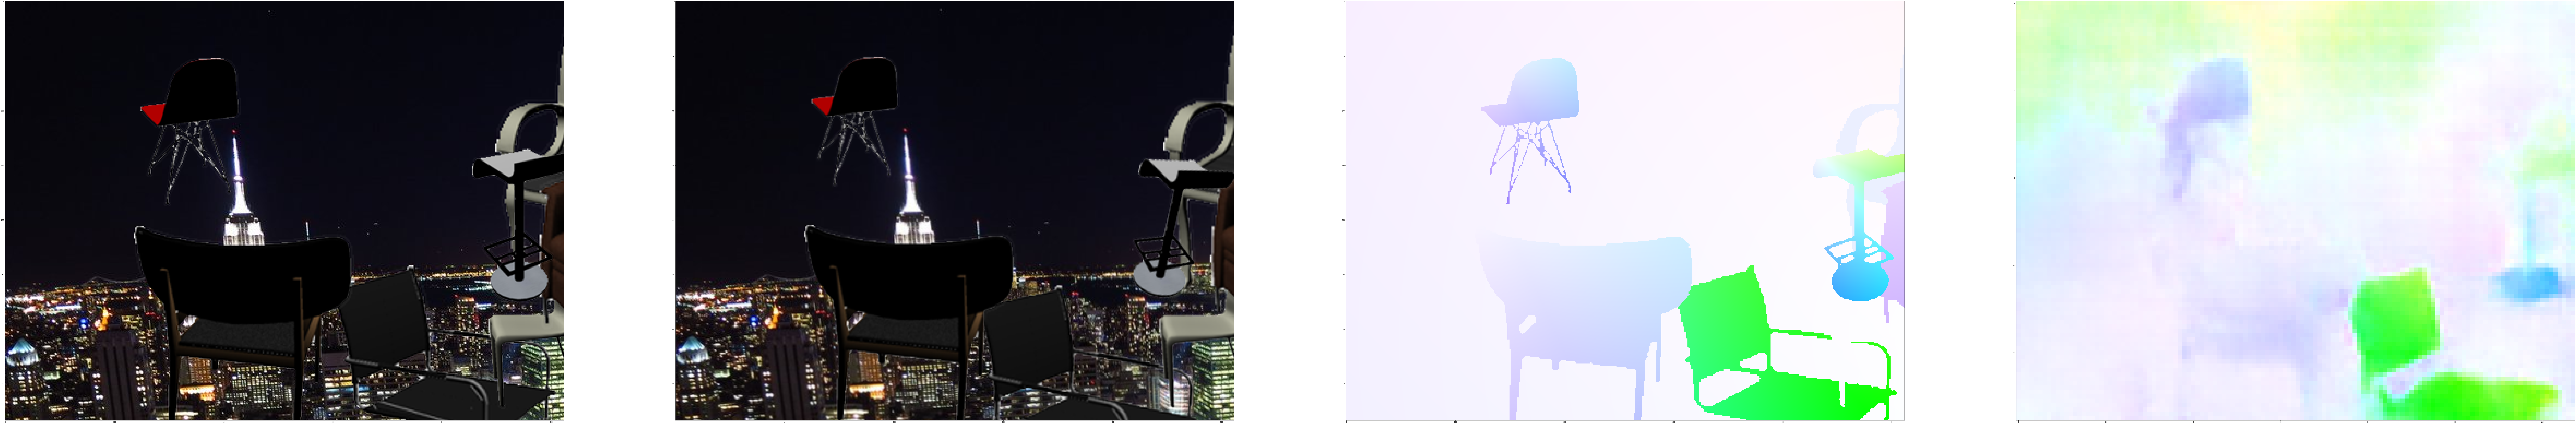

In [198]:
img1 = plt.imread('flying_chairs_samples/00001_img1.ppm')
img2 = plt.imread('flying_chairs_samples/00001_img2.ppm')
flow= load_flo('flying_chairs_samples/00001_flow.flo')

flow=fz.convert_from_flow(flow) #i use flowviz to convert flow to image

y=computeFlow(img1,img2,model)
plt.figure(figsize = (300,200))

plt.subplot(1, 4, 1)
plt.imshow(img1/255)
plt.subplot(1, 4, 2)
plt.imshow(img2/255)
plt.subplot(1, 4, 3)
plt.imshow(flow)
plt.subplot(1, 4, 4)
plt.imshow(y)

## VIDEO PIPELINE 

In [199]:
# 1- video acquisition
frames = import_video(video_path)    

Readed 778  frames 


In [200]:
# 2- flow computation
flow_frames=flow_video(frames)
saveVideo(flow_frames,"fhd2-flow2NotTuned")

  0%|          | 0/777 [00:00<?, ?it/s]

  0%|          | 0/777 [00:00<?, ?it/s]

In [201]:
#  3A means over frames if video is too noisy  Flow means (in order to remove noise)
# aver_flow=average_video(flow_frames, buffer=2)
# saveVideo(aver_flow,"avg-fhd2-flow")

In [202]:
# 3B- Find miving cordinates of center of gravity of our athlet
comp, x,y=find_center_of_gravity(flow_frames)  
saveVideo(comp,"mass_video",bw=True)

  0%|          | 0/777 [00:00<?, ?it/s]

  0%|          | 0/777 [00:00<?, ?it/s]

## SIGNAL ANALISYS

###  def utility for signal analisi

In [219]:

def gauss(n=11,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

def moving_average(x, k):
    return np.convolve(x, np.ones(k), 'valid')/k 


def normalize_zero_mean(sign):
    m= np.mean(sign)
    processed= sign- m
    return processed
norm=normalize_zero_mean(y)

def absolute(sign):
    return np.where(sign > 0 , sign , -sign  )

def findKeyPoint(y, meanLenght=5):
    """
    finds peaks on the graph, choice orientation 1 for positive movement (like pull up), -1 for negative (like push up)
    """
    peaks=[]
    y= moving_average(y,k=7)
    Peaks,_= find_peaks(y,distance=10,prominence=40)
    return peaks

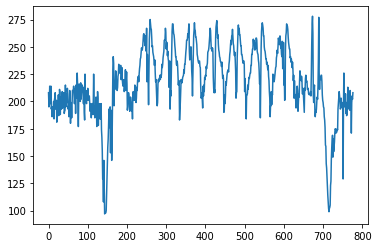

In [204]:
fig, ax = plt.subplots()
ax.plot(y)
plt.show()

In [205]:
# # 1- get zero mean data
# norm=normalize_zero_mean(y)
# absolut= absolute(norm)
# fig, ax = plt.subplots()
# ax.plot(absolut)
# plt.show()

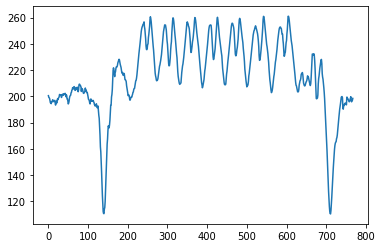

In [206]:
# 2- mobile average
avg=moving_average(y,k=10)
fig, ax = plt.subplots()
ax.plot(avg)
plt.show()

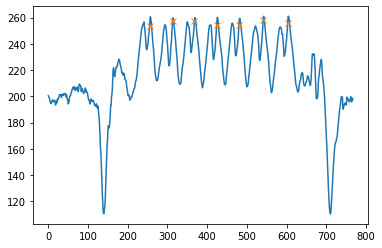

In [217]:
# 3- find peacks positive
peaks= findKeyPoint(avg)


np.diff(peaks)
plt.plot(avg)
plt.plot(peaks, avg[peaks], "x")
plt.show()


In [214]:
print(peaks)


[138 272 330 386 443 499 561 708]


In [218]:
video=save_key_frames(frames, peaks,threshold=40, near=13) 
saveVideo(video,"video_allenamento_dip2", frames_rate=60)

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/1634 [00:00<?, ?it/s]

In [210]:
# k_video = kmeans_video(flow_frames)
# saveVideo(k_video,"k_video")